## Notebook for 1D BDT scan and calculating FOMs in Bd2psi2SKS on data


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import ROOT
from ROOT import TFile, TH1D, TH2D, TCanvas, gStyle, TLine, TTree
from ROOT import (RooArgSet, RooRealVar, RooDataSet, RooPlot, RooFit, RooStats, RooArgList)

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from root_pandas import read_root
import pandas as pd

sys.path.append('/home/vmueller/repos')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls
from dopy.doplot.plotting import Plotter, Plot                

In [2]:

from ROOT import RooRealVar, RooExponential, RooExtendPdf, RooAddPdf, RooArgList, RooGaussian
from ROOT import RooFormulaVar
from ROOT import gSystem
gSystem.Load('libRooFit.so')
gSystem.Load('/home/chasenberg/repos/dopy/dolib/CustomShapes/libKll')
from ROOT import RooIpatia2

### Define dataset paths

### Read in TFile and TTree

In [3]:
# Read data and fit it
data = ROOT.TFile('/fhgfs/users/chasenberg/data/2015_2016/jpsiks/dimuon/with_cut/Bd2JpsiKS_dimuon_data_2015_2016_flat_BDT_cut_reduced.root')
dataset_tree = data.Get('Bd2JpsiKs') 
#ntupleVarSet =  RooArgSet(mass) 

### Define observables

In [4]:
obsMassJpsiKSConst = RooRealVar( 'B0_M','obsMassJpsiKSConst', 5280,5220, 5350, 'MeV/#it{c}^{2}')
B0_TAU             = RooRealVar( 'B0_TAU','B0_TAU', 0.00019, 0.1, 'ps')
B0_TAUERR          = RooRealVar( 'B0_TAUERR','B0_TAUERR', 0.0000045, 0.0017, 'ps')
BDTresponse        = RooRealVar('BDTresponse','BDTresponse',  0.00049, 7.5)
B0_TAGDECISION_OS  = RooRealVar('B0_TAGDECISION_OS','B0_TAGDECISION_OS',  -1, 1)
B0_TAGOMEGA_OS   = RooRealVar('B0_TAGOMEGA_OS','B0_TAGOMEGA_OS',  0.0, 0.5)
#catTrackType        = RooRealVar('catTrackType', 'catTrackType', 33, 33)

observables = RooArgSet(obsMassJpsiKSConst)
observables.add(B0_TAU)
observables.add(B0_TAUERR)
observables.add(BDTresponse)
observables.add(B0_TAGDECISION_OS)
observables.add(B0_TAGOMEGA_OS)
#observables.add(catTrackType)

True

In [5]:
#B0_M = RooRealVar("B0_FitDaughtersConst_M", "B0_M", 5280, "MeV")
#mass = RooRealVar("B0_FitDaughtersConst_M", "Mass(J/psi K_{S})", 5280,5220, 5350, "MeV")

### Check imported dataset

In [6]:
data_after_import = RooDataSet('data_after_import', 'data_after_import', dataset_tree, observables)
print('{:<10} {:<10}'.format('nBefore','nAfter'))
print('{:<10} {:<10}'.format(dataset_tree.GetEntries(),data_after_import.numEntries()))
data_sets = [None, None, data_after_import]
data_after_import.get(0).Print('v')

nBefore    nAfter    
100000     16938     


In [7]:
dataset_tree.GetEntries()

100000

### Function to build mass model

In [8]:
def build_mass_model(mass):


    par_ipatia_zeta  = RooRealVar('par_ipatia_zeta'  + postfix,  'par_ipatia_zeta'  + postfix, 2.8, 0.3, 5.3)
    par_ipatia_fb    = RooRealVar('par_ipatia_fb'    + postfix,    'par_ipatia_fb'  + postfix, 0., 0., 0.)
    par_ipatia_l     = RooRealVar('par_ipatia_l'     + postfix,     'par_ipatia_l'  + postfix, 1., 1., 1.)
    par_ipatia_m     = RooRealVar('par_ipatia_m'     + postfix,     'par_ipatia_m'  + postfix, 5280, 5220., 5350.,)
    par_ipatia_sigma = RooRealVar('par_ipatia_sigma' + postfix, 'par_ipatia_sigma'  + postfix, 8., 2., 100.)
    par_ipatia_a1    = RooRealVar('par_ipatia_a1'    + postfix,     'par_ipatia_a1' + postfix, 2.1)#, 0.01, 4)
    par_ipatia_a2    = RooRealVar('par_ipatia_a2'    + postfix,     'par_ipatia_a2' + postfix, 2.1)#, 0.01, 4)
    par_ipatia_n1    = RooRealVar('par_ipatia_n1'    + postfix,     'par_ipatia_n1' + postfix, 3.8)#, 0.00001, 150.)
    par_ipatia_n2    = RooRealVar('par_ipatia_n2'    + postfix,     'par_ipatia_n2' + postfix, 7.0)#, 0.00001, 150.)

    pdf_mass_ipatia  = ROOT.RooIpatia2('pdf_mass_ipatia', 'pdf_mass_ipatia', mass, par_ipatia_l, par_ipatia_zeta, par_ipatia_fb,
                               par_ipatia_sigma, par_ipatia_m, par_ipatia_a1, par_ipatia_n1,
                               par_ipatia_a2, par_ipatia_n2)
    
    ROOT.SetOwnership( pdf_mass_ipatia, False )
    ROOT.SetOwnership( par_ipatia_zeta, False )
    ROOT.SetOwnership( par_ipatia_fb, False )
    ROOT.SetOwnership( par_ipatia_l, False )
    ROOT.SetOwnership( par_ipatia_m, False )
    ROOT.SetOwnership( par_ipatia_sigma, False )
    ROOT.SetOwnership( par_ipatia_a1, False )
    ROOT.SetOwnership( par_ipatia_n1, False )
    ROOT.SetOwnership( par_ipatia_a2, False )
    ROOT.SetOwnership( par_ipatia_n2, False )

    sig_yield = RooRealVar('sig_yield' + postfix, 'sig_yield' + postfix, 100, 0, 1000000)
    ROOT.SetOwnership( sig_yield, False )

    sig_pdf_ext = RooExtendPdf('sig_pdf_ext' + postfix, 'sig_pdf_ext' + postfix, pdf_mass_ipatia, sig_yield)
    ROOT.SetOwnership( sig_pdf_ext, False )
    
    exp_a = RooRealVar('exp_a' + postfix, 'exp_a' + postfix, -0.001, -0.01, -0.00001)
    exp   = RooExponential('exp' + postfix, 'exp' + postfix, mass, exp_a)
    bkg_pdf = exp
    bkg_yield = RooRealVar('bkg_yield' + postfix, 'bkg_yield' + postfix, 5000, 0, 1000000)
    ROOT.SetOwnership( exp_a, False )
    ROOT.SetOwnership( bkg_pdf, False )
    ROOT.SetOwnership( bkg_yield, False)
    
    bkg_pdf_ext = RooExtendPdf('bkg_pdf_ext' + postfix, 'bkg_pdf_ext' + postfix, bkg_pdf, bkg_yield)
    ROOT.SetOwnership( bkg_pdf_ext, False)
    
    par_ipatia_m_bs_shift = RooRealVar("par_ipatia_m_bs_shift" + postfix, "par_ipatia_m_bs_shift" + postfix, 87.0, 50.0, 100.0)
    par_ipatia_m_bs = RooFormulaVar("par_ipatia_m_bs" + postfix, "par_ipatia_m_bs" + postfix, "@0+@1", RooArgList(par_ipatia_m, par_ipatia_m_bs_shift))
    #par_ipatia_m_bs     = RooRealVar("par_ipatia_m_bs"    + postfix,    "par_ipatia_m_bs" + postfix,    5366, 5300., 5400.,)
                    
    pdf_mass_ipatia_bs  = ROOT.RooIpatia2('pdf_mass_ipatia_bs', 'pdf_mass_ipatia_bs', mass, par_ipatia_l, par_ipatia_zeta, par_ipatia_fb,
                                          par_ipatia_sigma, par_ipatia_m_bs, par_ipatia_a1, par_ipatia_n1, par_ipatia_a2, par_ipatia_n2)
    
    bs_yield = RooRealVar('bs_yield' + postfix, 'bs_yield' + postfix, 0, 0, 0)# 5000, 0, 1000000)
    ROOT.SetOwnership( par_ipatia_m_bs_shift, False )
    ROOT.SetOwnership( par_ipatia_m_bs, False)
    ROOT.SetOwnership( bs_yield, False)
    ROOT.SetOwnership( pdf_mass_ipatia_bs, False)
    
    bs_pdf_ext = RooExtendPdf('bs_pdf_ext' + postfix, 'bs_pdf_ext' + postfix, pdf_mass_ipatia_bs, bs_yield)
    ROOT.SetOwnership( bs_pdf_ext, False)
    
    data_model = RooAddPdf('model' + postfix, 'model' + postfix, RooArgList(sig_pdf_ext, bkg_pdf_ext, bs_pdf_ext))
    ROOT.SetOwnership( data_model, False )
    
    return data_model

### Function to copy a tree and append sWeights

In [9]:
def copy_ttree_append_sweights(ttree_or_chain, dataset_with_weights):
    sweight_sig = array('d', [0.0])
    sweight_bkg = array('d', [0.0])
    sweight_bs = array('d', [0.0])
        
    sig_sweight_branch = ttree_or_chain.Branch('sweight_sig',sweight_sig,'sweight_sig/D')
    bkg_sweight_branch = ttree_or_chain.Branch('sweight_bkg',sweight_bkg,'sweight_bkg/D')
    bs_sweight_branch = ttree_or_chain.Branch('sweight_bs',sweight_bkg,'sweight_bs/D')

    for i in range(ttree_or_chain.GetEntries()):
        ttree_or_chain.GetEntry(i)
        control_branch_name = 'obsMassJpsiKSConst'
        if (ttree_or_chain.GetBranch('obsMassJpsiKSConst').GetLeaf('obsMassJpsiKSConst').GetValue() + 0.01 > dataset_with_weights.get(i)['obsMassJpsiKSConst'].getValV() and\
            ttree_or_chain.GetBranch('obsMassJpsiKSConst').GetLeaf('obsMassJpsiKSConst').GetValue() - 0.01 < dataset_with_weights.get(i)['obsMassJpsiKSConst'].getValV()):
            # print('Success in Event {}'.format(i))
            sweight_sig[0]=data_fit_cut.get(i)['sig_yield_sw'].getValV()
            sweight_bkg[0]=data_fit_cut.get(i)['bkg_yield_sw'].getValV()
            sweight_bs[0]=data_fit_cut.get(i)["bs_yield_sw"].getValV()
            sig_sweight_branch.Fill()
            bkg_sweight_branch.Fill()
            bs_sweight_branch.Fill()
        else:
            print('ERROR')
            sweight_sig[0]=-10000
            sweight_bkg[0]=-10000
            sweight_bs[0]=-10000
            sig_sweight_branch.Fill()
            bkg_sweight_branch.Fill()
            bs_sweight_branch.Fill()
    return ttree_or_chain

### Function to calculate the fit performance (standard FOMs)

In [10]:
def fill_performance(final_model, mass, performance_dict):
    sig_pdf = final_model.getComponents().find('sig_pdf_ext')
    bkg_pdf = final_model.getComponents().find('bkg_pdf_ext')
    
    massset = RooArgSet(mass)
    intbkg_sigregion = bkg_pdf.createIntegral(massset, RooFit.NormSet(massset), RooFit.Range('SIGREGION'))
    intsig_sigregion = sig_pdf.createIntegral(massset, RooFit.NormSet(massset), RooFit.Range('SIGREGION'))
    
    sig_yield = final_model.getParameters(data_fit_cut).find('sig_yield').getVal()
    bkg_yield = final_model.getParameters(data_fit_cut).find('bkg_yield').getVal()
    sig_yield = intsig_sigregion.getVal()*sig_yield
    bkg_yield = intbkg_sigregion.getVal()*bkg_yield
    s_over_b = sig_yield/bkg_yield
    s_over_spb = sig_yield/(sig_yield+bkg_yield)
    s_over_sqrt_b = sig_yield/math.sqrt(bkg_yield)
    s_over_sqrt_spb = sig_yield/math.sqrt(sig_yield+bkg_yield)
    s3_over_spb2 = (sig_yield**3)/(sig_yield+bkg_yield)**2
        
    performance_dict['sig_yield']       = sig_yield
    performance_dict['bkg_yield']       = bkg_yield
    performance_dict['s_over_b']        = s_over_b
    performance_dict['s_over_sqrt_b']   = s_over_sqrt_b
    performance_dict['s_over_spb']      = s_over_spb
    performance_dict['s_over_sqrt_spb'] = s_over_sqrt_spb
    performance_dict['s3_over_spb2']    = s3_over_spb2

### Function to get values and uncertainities of the fit parameters

In [11]:
def fill_shape(args, shape_dict):
    varnames = []
    varnames.append('par_ipatia_a1')
    varnames.append('par_ipatia_a2')
    varnames.append('par_ipatia_n1')
    varnames.append('par_ipatia_n2')
    varnames.append('par_ipatia_l')
    varnames.append('par_ipatia_sigma')
    varnames.append('par_ipatia_m')
    varnames.append('par_ipatia_m_bs_shift')
    varnames.append('par_ipatia_fb')
    varnames.append('exp_a')
    
    for varname in varnames:
        var = args.find(varname)
        shape_dict[varname+'_value'] = var.getValV()
        shape_dict[varname+'_errlo'] = var.getErrorLo()
        shape_dict[varname+'_errhi'] = var.getErrorHi()

### Function to print parameter info 

In [12]:
def parameter_info(old):
    print('\n')
    iter = old.createIterator()
    var = iter.Next()
    const_or_float = None
    print('INFO parameter_info: {:<20} {:<16} {:<16} {:<16} {:<16}'.format('Name', 'Value', 'Min', 'Max', 'Status'), flush=True)
    while var:
        if var.isConstant():
            const_or_float = 'const'
        else:
            const_or_float = 'float'
        print('INFO parameter_info: {:<25} {:<16.8} {:<16} {:<16} {:<16}'.format(var.GetName(), var.getValV(), var.getMin(), var.getMax(), const_or_float), flush=True)
        var=iter.Next()
    print('\n')

### Function to copy old fit results to new init file

In [13]:
def copy_old_new(old, new, verbose=False):
    iter = old.createIterator()
    var = iter.Next()
    const_or_float = None
    while var:
        new.find(var.GetName()).setMin(var.getMin())
        new.find(var.GetName()).setMax(var.getMax())
        new.find(var.GetName()).setVal(var.getValV())
        if verbose:
            print('copying ' + var.GetName())
        if var.isConstant():
            const_or_float = 'const'
            new.find(var.GetName()).setConstant()
        else:
            const_or_float = 'float'
        var=iter.Next()

### Function to calculate the FOMs

In [14]:
def calculate_foms(dataset):
    import math
    
    signal_sum    = 1
    cbkg_sum      = 0
    signal_sumw2  = 1
    
    signal_sum_tag_decis = 0 # count two ways to check consistency
    signal_sum_tag_omega = 0

    D_bs_perfect  = 0
    D_bs_perftagg = 0
    D_bs_perfterr = 0
    D_bs          = 0
    D_bd          = 0
    D_bd_perfect  = 0
    Q_bs_perfect  = 0
    Q_bs_perftagg = 0
    Q_bs_perfterr = 0
    Q_bs          = 0
    Q_bd          = 0
    Q_bd_perfect  = 0
    
    delta_m = 0.5065 
    S = 0.691 #sin2beta value (average from HFAG)
    
    tagging_power = 0
    timeres_power = 0
    
    for i in range(dataset.numEntries()):
        signal_weight =  dataset.get(i)['sig_yield_sw'].getValV()
        cbkg_weight   =  dataset.get(i)['bkg_yield_sw'].getValV()
        mistag        =  data_fit_cut.get(i)['B0_TAGOMEGA_OS'].getValV()
        tag           = data_fit_cut.get(i)['B0_TAGDECISION_OS'].getValV()
        decaytime     = data_fit_cut.get(i)['B0_TAU'].getValV()
        timeerror     =  data_fit_cut.get(i)['B0_TAUERR'].getValV()

        
        signal_sum    += signal_weight
        signal_sumw2  += signal_weight**2
        cbkg_sum      += cbkg_weight
        
        if mistag != 0.5:
            signal_sum_tag_omega += signal_weight
        if tag != 0:    
            signal_sum_tag_decis += signal_weight
        if (tag != 0 and mistag == 0.5) or (tag == 0 and mistag != 0.5):
            print('ERROR: mismatch tag {} mistag {}'.format(tag, mistag))
        
        nominator_bd_term   = math.sin(delta_m * decaytime)
        denominator_bd_term = 1 + tag * (1 - 2 * mistag) * S * math.exp(-0.5*(delta_m*timeerror)**2)*math.sin(delta_m*decaytime)       
        bd_term = (nominator_bd_term/denominator_bd_term)**2
        
        denominator_bd_term_perfect = 1 + tag * 1 * S * 1 *math.sin(delta_m*decaytime)
        bd_term_perfect = (nominator_bd_term/denominator_bd_term_perfect)**2
        
        tagging_dilution  = (1 - 2*mistag)**2
        timeerror_dilution = math.exp(-(delta_m*timeerror)**2)

        timeres_power    += timeerror_dilution*signal_weight
        tagging_power    += tagging_dilution*signal_weight
        
        D_bs_perfect      += 1                * 1                  * 1               * signal_weight
        D_bs_perftagg     += 1                * timeerror_dilution * 1               * signal_weight
        D_bs_perfterr     += tagging_dilution * 1                  * 1               * signal_weight
        D_bs              += tagging_dilution * timeerror_dilution * 1               * signal_weight
        D_bd              += tagging_dilution * timeerror_dilution * bd_term         * signal_weight
        D_bd_perfect      += 1                * 1                  * bd_term_perfect * signal_weight

    effsigsize = signal_sum**2 / signal_sumw2
    
    if (signal_sum_tag_omega != signal_sum_tag_decis):
        print('ERROR: counting sweights via omega!=0.5 and decision!=0 led to different results')
        print('ERROR: this should not happen! - tagging efficiency is not well defined')
        print('ERROR: omega counting: {}   tag counting: {}'.format(signal_sum_tag_omega, signal_sum_tag_decis))
        
    tagging_dilution_avg_tagged = tagging_power / signal_sum_tag_omega
    tagging_efficiency = signal_sum_tag_omega / signal_sum
    
    tagging_power /= signal_sum
    timeres_power /= signal_sum

    D_bs_perfect  /= signal_sum#dataset.numEntries()
    D_bs_perftagg /= signal_sum#dataset.numEntries()
    D_bs_perfterr /= signal_sum#dataset.numEntries()
    D_bs          /= signal_sum#dataset.numEntries()
    D_bd          /= signal_sum#dataset.numEntries()
    D_bd_perfect  /= signal_sum#dataset.numEntries()
        
    Q_bs_perfect  = effsigsize * D_bs_perfect #signal_sum**2 / dataset.numEntries() * D_bs_perfect
    Q_bs_perftagg = effsigsize * D_bs_perftagg #signal_sum**2 / dataset.numEntries() * D_bs_perftagg
    Q_bs_perfterr = effsigsize * D_bs_perfterr #signal_sum**2 / dataset.numEntries() * D_bs_perfterr
    Q_bs          = effsigsize * D_bs #signal_sum**2 / dataset.numEntries() * D_bs
    Q_bd          = effsigsize * D_bd #signal_sum**2 / dataset.numEntries() * D_bd
    Q_bd_perfect  = effsigsize * D_bd_perfect #signal_sum**2 / dataset.numEntries() * D_bd
    
    fomname_to_value = {
        'EffSigSize'   : effsigsize,
        'TaggingPower' : tagging_power,
        'TaggingDavg'  : tagging_dilution_avg_tagged,
        'TaggingEff'   : tagging_efficiency,
        'TimeresPower' : timeres_power,
        'BsFOM_p'      : Q_bs_perfect,
        'BsFOM_pTim'   : Q_bs_perfterr,
        'BsFOM_pTag'   : Q_bs_perftagg,
        'BsFOM'        : Q_bs,
        'BdFOM'        : Q_bd,
        'BdFOM_p'      : Q_bd_perfect
    }

    return fomname_to_value       

### Configure  and define cuts 

In [15]:
lowerbound=5220 # rather arbitrary signal window definition
upperbound=5350
obsMassJpsiKSConst.setRange('SIGREGION',lowerbound,upperbound)

subdir = '/home/chasenberg/plots/bdt_cuttuning'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')


if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
mass_var_name = 'obsMassJpsiKSConst'
cuttype = 'BDTresponse'

cuts = np.linspace(-6,6,10)
#cuts = [-0.05]
cuts_for_which_to_store_sdata = []   

cut_to_performance = {} 
cut_to_shape = {}

perform_fit = True
do_splot    = True
postfix = ''
final_params_file = None
oldParameters = None
final_model = None

### Fit, sWeights, calculate FOMs, plot

In [16]:
from ROOT import RooArgList

x=None
for cut in cuts:
    print('INFO: Starting to test cut ' + '{0}>{1}'.format(cuttype,cut), flush=True)
    data_fit_cut = data_after_import.reduce('{0}>{1}'.format(cuttype,cut))
    
    print('INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data', flush=True) 
    final_model = build_mass_model(obsMassJpsiKSConst)
  
    parameters_file_name  = 'params' + postfix + cuttype + str(cut) + '.txt';
    parameters_init_name  = parameters_file_name.replace('.txt', '_init.txt')
    parameters_final_name = parameters_file_name.replace('.txt', '_final.txt')
    
    if os.path.exists(os.path.join(results_dir, parameters_init_name)):
        print('INFO: Reading parameters from configfile '  + os.path.join(results_dir, parameters_init_name), flush=True)
        final_model.getParameters(data_fit_cut).readFromFile(os.path.join(results_dir, parameters_init_name))
        if oldParameters:
            print('INFO: Read following parameters from configfile:', flush=True)
            final_model.getParameters(data_fit_cut).Print('v')
    else:
        print('INFO: configfile... '  + os.path.join(results_dir, parameters_init_name) + ' does not exist', flush=True)
        print('INFO: Will try to copy parameters from last fit to get proper starting values', flush=True)
        if oldParameters:
            copy_old_new(oldParameters, final_model.getParameters(data_fit_cut))
        else:
            print('INFO: This is the first fit, cannot copy')
        
    if perform_fit:
        print('INFO: Starting fit', flush=True)
        fit_result = final_model.fitTo(data_fit_cut,
                                      RooFit.NumCPU(6),
                                      RooFit.Minimizer('Minuit','minimize'),
                                      RooFit.Hesse(True),
                                      RooFit.Optimize(0),
                                      RooFit.PrintEvalErrors(0),
                                      RooFit.Save(True),
                                      RooFit.Extended(),
                                      RooFit.Verbose(True))

        if fit_result:
            fit_result.Print('v')
            fit_result.correlationMatrix().Print('v')
            if fit_result.status()==0:
                print('INFO: Fit converged')
            else:
                print('INFO: Status '+str(fit_result.status()))
            print('INFO: Fit complete', flush=True)
        else:
            print('ERROR: There is no fitresult', flush=True)
        
    final_params_file = os.path.join(results_dir, parameters_final_name)
    final_model.getParameters(data_fit_cut).writeToFile(final_params_file)
    oldParameters = final_model.getParameters(data_fit_cut).snapshot()

    cut_to_shape[cut] = {}
    fill_shape(oldParameters, cut_to_shape[cut])
    
   
    cut_to_performance[cut] = {}
    fill_performance(final_model, obsMassJpsiKSConst, cut_to_performance[cut])
    
    sig_num = []
    bkg_num = []
    if do_splot:
        print('INFO: Calculating sWeights', flush=True)
        iter = final_model.getParameters(data_fit_cut).createIterator()
        var = iter.Next()
        while var:
            # print(var.GetName())
            if not 'yield' in var.GetName():
                # print('Setting {} constant'.format(var.GetName()), flush=True)
                var.setConstant()
            var=iter.Next()
            
        var_sig_yield = final_model.getParameters(data_fit_cut).find('sig_yield')
        var_bkg_yield = final_model.getParameters(data_fit_cut).find('bkg_yield')
        var_bs_yield = final_model.getParameters(data_fit_cut).find('bs_yield')
        sData = RooStats.SPlot('sData', 'sData', data_fit_cut, final_model, RooArgList(var_sig_yield,var_bkg_yield,var_bs_yield))
        foms = calculate_foms(data_fit_cut)
        cut_to_performance[cut].update(foms)
        sig_num.append(var_sig_yield.getValV())
        bkg_num.append(var_bkg_yield.getValV())
        print('INFO: Finished calculating sWeights', flush=True)
            
        if cut in cuts_for_which_to_store_sdata:
            from ROOT import TFile
            from array import array
                
            filename_sweighted_data = dataset_file_name.replace('.root', '_sW{}{}.root'.format(cuttype,cut))
            f_all_new = TFile(filename_sweighted_data, 'RECREATE')
            tree_w_obscuts = dataset_tree.CopyTree('{0}>{1}'.format(cuttype,cut))
            print('INFO: Entries in TTree: {}'.format(tree_w_obscuts.GetEntries()))
            print('INFO: Entries in Dataset: {}'.format(data_fit_cut.numEntries()))
            copy_ttree_append_sweights(tree_w_obscuts, data_fit_cut)
            tree_w_obscuts.Write()
            f_all_new.Close()
    
    print('INFO: Start plotting', flush=True)
    sys.path.append('/home/vmueller/repos/root_utils/')
    from ROOT import TColor
    import rootnotes  # For displaying TCanvas in notebooks
    from lhcb_style import set_lhcb_style # Set basic LHCb plot style
    set_lhcb_style()   
    from root_utils import plot_pulls

    sig_set = ROOT.RooArgSet(final_model.getComponents().find('sig_pdf_ext'))
    bkg_set = ROOT.RooArgSet(final_model.getComponents().find('bkg_pdf_ext'))
    bs_set = ROOT.RooArgSet(final_model.getComponents().find('bs_pdf_ext'))

    # Prepare frame
    plot_frame = obsMassJpsiKSConst.frame(ROOT.RooFit.Bins(100))
    data_fit_cut.plotOn(plot_frame, ROOT.RooFit.Name('data'))
    final_model.plotOn(plot_frame, RooFit.Components(sig_set), RooFit.LineStyle(2), RooFit.LineColor(226), ROOT.RooFit.Name('sig_fit'))
    final_model.plotOn(plot_frame, RooFit.Components(bs_set), RooFit.LineStyle(3), RooFit.LineColor(410), ROOT.RooFit.Name('bs_fit'))
    final_model.plotOn(plot_frame, RooFit.Components(bkg_set), RooFit.LineStyle(8), RooFit.LineColor(96), ROOT.RooFit.Name('bkg_fit'))
    final_model.plotOn(plot_frame,RooFit.LineColor(1))

    ### Add additional informations to the plot
    text_size = 0.035
    # Create TLegend
    legend = ROOT.TLegend(0.7, 0.75, 0.9, 0.9)
    legend.AddEntry(plot_frame.findObject('data'), 'Data', 'p')
    legend.AddEntry(plot_frame.findObject('sig_fit'), '#it{B}^{0}#rightarrow#it{#psi(2S)}#it{K}_{#kern[-0.3]{S}}', 'l')
    legend.AddEntry(plot_frame.findObject('bs_fit'), '#it{B}^{0}_{s}#rightarrow#it{#psi(2S)}#it{K}_{#kern[-0.3]{S}}', 'l')
    legend.AddEntry(plot_frame.findObject('bkg_fit'), 'Comb. background', 'l')
    
    
    legend.SetTextSize(text_size)

    # Plot pulls
    plotname = 'plot' + postfix + cuttype + str(cut)
    can, _ = plot_pulls(plotname, plot_frame, legend=legend, save_path= subdir + '/plots/', logy=True) 
    can  # To display plot in notebooks
    print('INFO: Finish plotting', flush=True)

INFO: Starting to test cut BDTresponse>-6.0
INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data
INFO: configfile... /home/chasenberg/plots/bdt_cuttuning/results/paramsBDTresponse-6.0_init.txt does not exist
INFO: Will try to copy parameters from last fit to get proper starting values
INFO: This is the first fit, cannot copy
INFO: Starting fit
INFO: Fit converged
INFO: Fit complete
INFO: Calculating sWeights
INFO: Finished calculating sWeights
INFO: Start plotting
INFO: Finish plotting
INFO: Starting to test cut BDTresponse>-4.666666666666667
INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data
INFO: configfile... /home/chasenberg/plots/bdt_cuttuning/results/paramsBDTresponse-4.66666666667_init.txt does not exist
INFO: Will try to copy parameters from last fit to get proper starting values
INFO: Starting fit
INFO: Fit converged
INFO: Fit complete
INFO: Calculating sWeights
INFO: Finished calculating sWeights


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Calculating sWeights
INFO: Finished calculating sWeights
INFO: Start plotting
INFO: Finish plotting
INFO: Starting to test cut BDTresponse>-2.0
INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data
INFO: configfile... /home/chasenberg/plots/bdt_cuttuning/results/paramsBDTresponse-2.0_init.txt does not exist
INFO: Will try to copy parameters from last fit to get proper starting values
INFO: Starting fit
INFO: Fit converged
INFO: Fit complete


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Calculating sWeights
INFO: Finished calculating sWeights
INFO: Start plotting
INFO: Finish plotting
INFO: Starting to test cut BDTresponse>-0.666666666666667
INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data
INFO: configfile... /home/chasenberg/plots/bdt_cuttuning/results/paramsBDTresponse-0.666666666667_init.txt does not exist
INFO: Will try to copy parameters from last fit to get proper starting values
INFO: Starting fit
INFO: Fit converged
INFO: Fit complete


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Calculating sWeights
INFO: Finished calculating sWeights
INFO: Start plotting
INFO: Finish plotting
INFO: Starting to test cut BDTresponse>0.6666666666666661
INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data
INFO: configfile... /home/chasenberg/plots/bdt_cuttuning/results/paramsBDTresponse0.666666666667_init.txt does not exist
INFO: Will try to copy parameters from last fit to get proper starting values
INFO: Starting fit
INFO: Fit converged
INFO: Fit complete


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Calculating sWeights
INFO: Finished calculating sWeights
INFO: Start plotting
INFO: Finish plotting
INFO: Starting to test cut BDTresponse>2.0
INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data
INFO: configfile... /home/chasenberg/plots/bdt_cuttuning/results/paramsBDTresponse2.0_init.txt does not exist
INFO: Will try to copy parameters from last fit to get proper starting values
INFO: Starting fit
INFO: Fit converged
INFO: Fit complete


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Calculating sWeights
INFO: Finished calculating sWeights
INFO: Start plotting
INFO: Finish plotting
INFO: Starting to test cut BDTresponse>3.333333333333332
INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data
INFO: configfile... /home/chasenberg/plots/bdt_cuttuning/results/paramsBDTresponse3.33333333333_init.txt does not exist
INFO: Will try to copy parameters from last fit to get proper starting values
INFO: Starting fit
INFO: Fit converged
INFO: Fit complete


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Calculating sWeights
INFO: Finished calculating sWeights
INFO: Start plotting
INFO: Finish plotting
INFO: Starting to test cut BDTresponse>4.666666666666666
INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data
INFO: configfile... /home/chasenberg/plots/bdt_cuttuning/results/paramsBDTresponse4.66666666667_init.txt does not exist
INFO: Will try to copy parameters from last fit to get proper starting values
INFO: Starting fit
INFO: Fit converged
INFO: Fit complete


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Calculating sWeights
INFO: Finished calculating sWeights
INFO: Start plotting
INFO: Finish plotting
INFO: Starting to test cut BDTresponse>6.0
INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data
INFO: configfile... /home/chasenberg/plots/bdt_cuttuning/results/paramsBDTresponse6.0_init.txt does not exist
INFO: Will try to copy parameters from last fit to get proper starting values
INFO: Starting fit
INFO: Fit converged
INFO: Fit complete


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


INFO: Calculating sWeights
INFO: Finished calculating sWeights
INFO: Start plotting
INFO: Finish plotting


TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: can
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_all (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_ok (Potential memory leak).
TFile::Append:0: RuntimeWarning: Replacing existing TH1: pulls_danger (Potential memory leak).


### Print the performance values

In [17]:
print("{:<6} {:<10} {:<10} {:<12} {:<12} {:<13} {:<10} {:<10} {:<10} {:<10}".format("BDT>", "Signal", "Background", "S/B" ,"S/S+B", "S/sqrt(S+B)", "S3/(S+B)2","FOM", "Q", "Q_Bd"))
cuts.sort()
for cut in cuts:
  performance = cut_to_performance[cut]
  print("{:<6.4} {:<10.6} {:<10.5} {:<12.4} {:<12.4} {:<13.4} {:<10.5} {:<10.5} {:<10.5} {:<10.5}".format(cut,
                                                                              performance["sig_yield"],
                                                                              performance["bkg_yield"],
                                                                              performance["s_over_b"],
                                                                              performance["s_over_spb"],
                                                                              performance["s_over_sqrt_spb"],
                                                                              performance["s3_over_spb2"],
                                                                              performance["EffSigSize"],
                                                                              performance["BsFOM"],
                                                                              performance["BdFOM"]))

BDT>   Signal     Background S/B          S/S+B        S/sqrt(S+B)   S3/(S+B)2  FOM        Q          Q_Bd      
-6.0   10612.5    6325.5     1.678        0.6266       81.54         4166.1     7319.7     189.53     0.0002305 
-4.667 10612.5    6325.5     1.678        0.6266       81.54         4166.1     7265.6     187.77     0.00022817
-3.333 10612.5    6325.5     1.678        0.6266       81.54         4166.1     7114.9     183.28     0.00022096
-2.0   10612.5    6325.5     1.678        0.6266       81.54         4166.1     7072.9     182.57     0.00021698
-0.6667 10612.5    6325.5     1.678        0.6266       81.54         4166.1     7076.0     182.76     0.00021694
0.6667 9299.05    3677.1     2.529        0.7166       81.63         4775.6     6835.1     180.49     0.00021723
2.0    6384.08    870.91     7.33         0.88         74.95         4943.4     5396.5     149.14     0.0002058 
3.333  3287.54    128.46     25.59        0.9624       56.25         3044.9     3040.8     82.7

### Print the FOMs

In [18]:
print("{:<6} {:<8} {:<8} {:<6} {:<7} {:<8} {:<8} {:<10} {:<12} {:<12} {:<10} {:<12}".format("BDT>",
                                                               "EffSig",
                                                               "TagPow",
                                                               "D",
                                                               "eff_t",
                                                               "BdFOM_p",
                                                               "TimPow",
                                                               "BsFOM_p",
                                                               "BsFOM_pTag" ,
                                                               "BsFOM_pTim",
                                                               "BsFOM",
                                                               "BdFOM"))
cuts.sort()
for cut in cuts:
  performance = cut_to_performance[cut]
  print("{:<6.3} {:<8.6} {:<8.3} {:<6.3} {:<7.3} {:<8.5} {:<8.4} {:<10.6} {:<12.6} {:<12.6} {:<10.6} {:<12.6}".format(cut,
                                                                             performance["EffSigSize"],
                                                                             performance["TaggingPower"],
                                                                             performance["TaggingDavg"],
                                                                             performance["TaggingEff"],
                                                                             performance["BdFOM_p"],
                                                                             performance["TimeresPower"],
                                                                             performance["BsFOM_p"],
                                                                             performance["BsFOM_pTag"],
                                                                             performance["BsFOM_pTim"],
                                                                             performance["BsFOM"],
                                                                             performance["BdFOM"]))

BDT>   EffSig   TagPow   D      eff_t   BdFOM_p  TimPow   BsFOM_p    BsFOM_pTag   BsFOM_pTim   BsFOM      BdFOM       
-6.0   7319.67  0.0259   0.0905 0.286   0.010776 0.9999   7318.98    7318.98      189.525      189.525    0.000230499 
-4.67  7265.58  0.0258   0.0904 0.286   0.010661 0.9999   7264.9     7264.9       187.767      187.767    0.000228171 
-3.33  7114.86  0.0258   0.0902 0.286   0.010393 0.9999   7114.19    7114.19      183.285      183.285    0.000220962 
-2.0   7072.93  0.0258   0.0903 0.286   0.010362 0.9999   7072.26    7072.26      182.57       182.57     0.00021698  
-0.667 7076.04  0.0258   0.0904 0.286   0.010375 0.9999   7075.37    7075.37      182.763      182.763    0.000216943 
0.667  6835.09  0.0264   0.0918 0.288   0.010367 0.9999   6834.35    6834.35      180.494      180.494    0.00021723  
2.0    5396.51  0.0276   0.0931 0.297   0.0080686 0.9998   5395.67    5395.67      149.137      149.137    0.000205796 
3.33   3040.79  0.0272   0.0911 0.299   0.00548

### Functions to unpack dictionaries (paramters and cuts)

In [19]:
import numpy as np
def unpack_parameter_to_nparray(parameter, cut_to_shape):
    x = np.array(list(cut_to_shape.keys()))
    x.sort()
    y_value = np.array([cut_to_shape[i][parameter+"_value"] for i in x])
    y_errlo = np.array([cut_to_shape[i][parameter+"_errlo"] for i in x])
    y_errhi = np.array([cut_to_shape[i][parameter+"_errhi"] for i in x])
    y_errors= abs(np.vstack([y_errlo,y_errhi]))
    return x, y_value, y_errors

def unpack_cut_dict(cut_dict, normalize=True):
    cuts = np.array(list(cut_dict.keys()))
    cuts.sort()
    
    new_dict = {}
    for cut in cuts:
        parameters_dict = cut_dict[cut]
        for parameter, value in parameters_dict.items():
            if parameter in new_dict:
                new_dict[parameter].append(value)
            else:
                new_dict[parameter] = [value]
    
    for parameter, values in new_dict.items():
        new_dict[parameter] = np.array(values)
        if normalize:
            new_dict[parameter] = values/np.max(np.abs(values))
    
    return cuts, new_dict

x, ys = unpack_cut_dict(cut_to_performance)
for parameter, values in ys.items():
    if "value" in parameter:
        print(values)
        y_errlo = np.array(ys[parameter.replace("_value","_errlo")])
        y_errhi = np.array(ys[parameter.replace("_value","_errhi")])
        y_errors= abs(np.vstack([y_errlo,y_errhi]))
        plt.errorbar(x,values,yerr=y_errors,marker='.',linestyle='', label='sigma')
        plt.xlabel(parameter)
        plotname = parameter + '.pdf'
        singleplot_file = os.path.join(plot_dir, plotname)
        plt.savefig(singleplot_file)
        plt.show()

### Plot FOMs

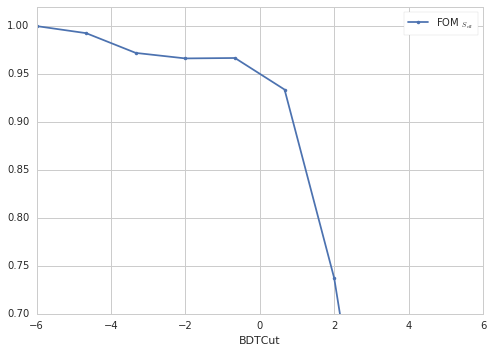

In [28]:
import random
import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("whitegrid", {"legend.frameon": True})

x, ys = unpack_cut_dict(cut_to_performance)
shift = 0.0

foms_to_plot = {}
#foms_to_plot["TaggingPower"] = r"FOM ${}_{\varepsilon D^2}$"
#foms_to_plot["TimeresPower"] = "FOM ${}_{\sigma_{t}}$"
foms_to_plot["EffSigSize"]   = "FOM ${}_{S_{\mathrm{eff}}}$"
#foms_to_plot["BsFOM"]        = "FOM ${}_{B^0_s}$"
#foms_to_plot["BdFOM_p"]      = "FOM ${}_{B^0_d}$"
#foms_to_plot["BdFOM"]        = "FOM"

#for parameter, values in ys.items():
for parameter in foms_to_plot:
    values=ys[parameter]
    #if "FOM" in parameter or "EffSig" in parameter or "s3_over_spb2" in parameter\
    #or "TaggingPower" in parameter or "TimeresPower" in parameter:
    if parameter in foms_to_plot:
        plt.errorbar(x,values+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter])
        plt.xlabel("BDTCut")

plt.gca().set_ylim(0.7,1.02)
plt.gca().set_xlim(-6,6)
plt.legend(loc='best')
plt.savefig(subdir + '/FOMS.pdf')
plt.show()

In [27]:
len(sig_num)

1